### List of tables:


1. [Table S1: Quality-quantity trade-off](#ols_quantity_quality)

### List of figures:

1. [Figure 3: Scatterplot quality vs. quantity](#scatter_quantity_quality)


In [1]:
%matplotlib inline

#### Imports libraries

In [2]:
import matplotlib.pyplot as plt #plotting
import numpy as np #matrix algebra
import os #file system handling
import pandas as pd #dataframe handling
import statsmodels.api as sm #regression analysis
import statsmodels.formula.api as smf # regressions analysis

from matplotlib.ticker import FuncFormatter #formating graphs 
from scipy import stats #statistics module
from statsmodels.iolib.summary2 import summary_col #regression output table
from statsmodels.stats.anova import anova_lm #regression anova table

#### Turn off pandas' future warnings

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Set project directory

In [4]:
PROJECT_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures')

#### Set display format

In [5]:
pd.options.display.float_format = '{:.3f}'.format

#### Set plotting style

In [6]:
plt.style.use('classic')

#### Set plotting properties 

In [7]:
bar_kwargs = dict(kind='bar', color='0.4', alpha=0.8, lw=0.5, width=0.7)
line_kwargs = dict(kind='line', lw=1, alpha=1, legend=True)
tick_kwargs = dict(size=5, which='both', right=False, top=False, direction='out', labelbottom=True)
font_kwargs = dict(fontsize=11, color='k')
grid_kwargs = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
xlabel_kwargs = dict(fontsize=11, labelpad=3)
ylabel_kwargs = dict(fontsize=11, labelpad=3)
e_kwargs = dict(elinewidth=2, ecolor='0.15')
legend_kwargs = dict(frameon=False)

#### Retrieving dataframe

In [8]:
DATA = os.path.join(FINAL_DATA_FOLDER, 'benefit_data.feather')
df = pd.read_feather(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3094 entries, 0 to 3093
Columns: 441 entries, age to question80_timer
dtypes: float64(223), int64(25), object(193)
memory usage: 10.4+ MB


#### Sort dataframe by treatment 

In [9]:
df = df.sort_values('treatment')

#### Exclude subjects for which the timer did not work (10 min +/- 5%)

In [10]:
broken_timer = (df.duration_work < 600 * 0.95)|(df.duration_work > 600 * 1.05)
df = df[~broken_timer]

#### Seperate quality concern-treatments from the following main analysys

In [11]:
sel = (df.dataset != 6)
df = df[sel]

#### Group datasets according to treatments

In [12]:
grouped_all = df.groupby('treatment_str')
grouped_first = df.groupby('treatment_first')
grouped_second = df.groupby('treatment_second')

#### Reshape dataframe for panel analysis 

In [13]:
columns_to_keep = df.columns[[0, 10, 12, 18, 19, 32, 33, 34, 35, 36, 37, 38]]
columns_to_melt = ['question{0}_editratio'.format(x) for x in range(1, df.counter.max() + 1)]

df_melted = pd.melt(
    df, 
    id_vars=columns_to_keep,
    value_vars = columns_to_melt,
    var_name='question_number',
    value_name='edit_ratio'
)

df_melted = df_melted.dropna(axis=0, how='any', subset=['edit_ratio'])
df_melted['question_number'] = df_melted['question_number'].str.extract(r'(\d+)').astype(int)
df_melted['edit_ratio'] = df_melted['edit_ratio'].astype(float)

df_panel = df_melted.set_index(['workerid', 'question_number'])
df_panel = df_panel.sort_index()
df_panel.head(20)  

age  education  female  latin  mobile_device  \
workerid question_number                                                   
0        1               43.000          2       1      2              0   
         2               43.000          2       1      2              0   
         3               43.000          2       1      2              0   
         4               43.000          2       1      2              0   
         5               43.000          2       1      2              0   
         6               43.000          2       1      2              0   
         7               43.000          2       1      2              0   
         8               43.000          2       1      2              0   
         9               43.000          2       1      2              0   
         10              43.000          2       1      2              0   
         11              43.000          2       1      2              0   
         12              43.000          2       1      2              0   
         13              43.000          2       1      2              0   
         14              43.000          2       1      2              0   
         15              43.000          2       1      2              0   
         16              43.000          2       1      2              0   
         17              43.000          2       1      2              0   
         18              43.000          2       1      2              0   
         19              43.000          2       1      2              0   
         20              43.000          2       1      2              0   

                          high_piece_rate  low_piece_rate  no_piece_rate  \
workerid question_number                                                   
0        1                              0               0              1   
         2                              0               0              1   
         3                              0               0              1   
         4                              0               0              1   
         5                              0               0              1   
         6                              0               0              1   
         7                              0               0              1   
         8                              0               0              1   
         9                              0               0              1   
         10                             0               0              1   
         11                             0               0              1   
         12                             0               0              1   
         13                             0               0              1   
         14                             0               0              1   
         15                             0               0              1   
         16                             0               0              1   
         17                             0               0              1   
         18                             0               0              1   
         19                             0               0              1   
         20                             0               0              1   

                          expectations  goal  neutral  edit_ratio  
workerid question_number                                           
0        1                           1     0        0       0.075  
         2                           1     0        0       0.020  
         3                           1     0        0       0.019  
         4                           1     0        0       0.039  
         5                           1     0        0       0.000  
         6                           1     0        0       0.020  
         7                           1     0        0       0.019  
         8                           1     0        0       0.019  
  

#### Calculate the time averaged error score and merge resuts with cross-sectional dataframe

In [14]:
avg_edit_ratio = df_panel['edit_ratio'].mean(level=0).to_frame(name='avg_edit_ratio')
df = df.merge(avg_edit_ratio, left_on='workerid', right_on='workerid', validate='one_to_one')

#### Figure 1: Scatterplots for number of fragments submitted vs. mean error score  <a id='scatter_quantity_quality'></a>

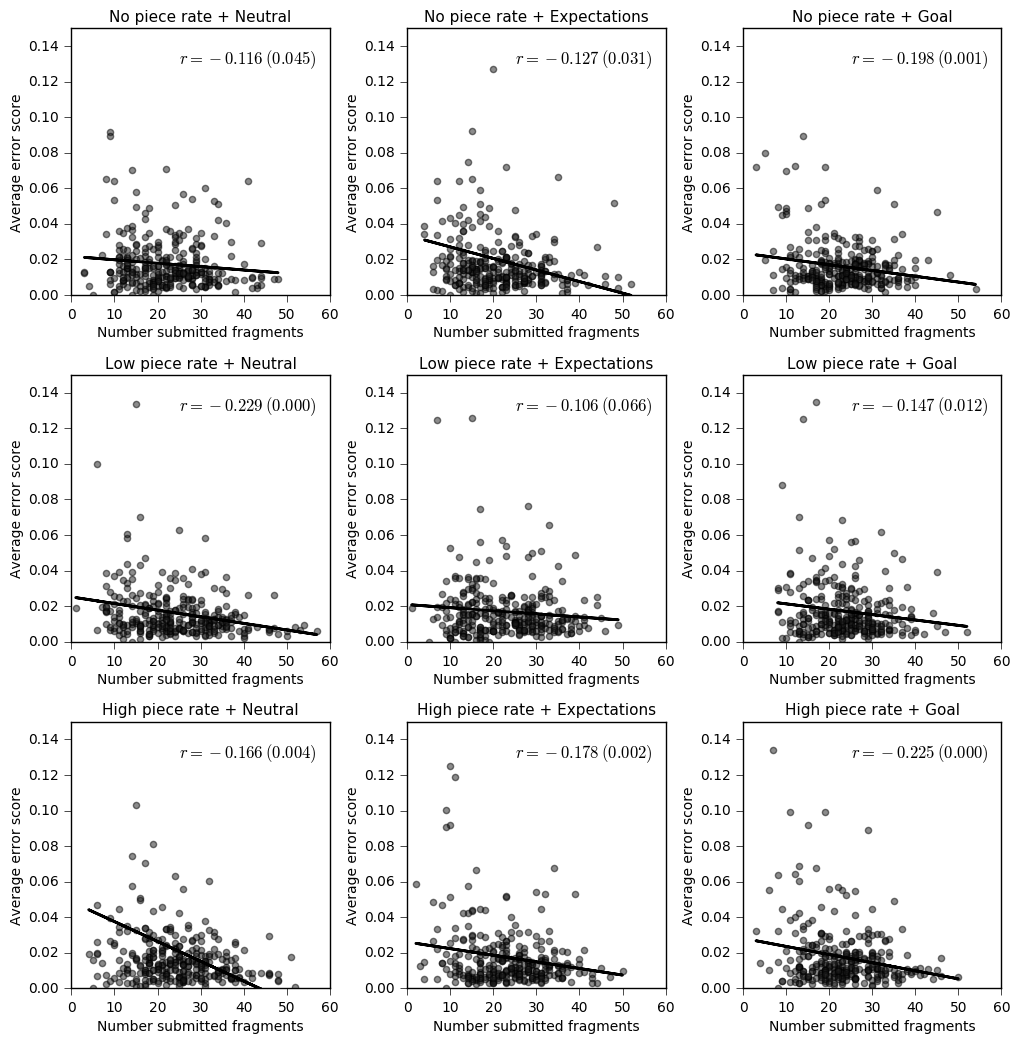

In [17]:
def get_fitted_values(df, x, y):
    y = df.loc[:,y]
    x = df.loc[:,x]
    x = sm.add_constant(x)
    ols = sm.OLS(y, x).fit()
    return ols.fittedvalues

x_var, y_var = 'counter_real', 'avg_edit_ratio'
scatter_params = dict(xlim=[0, 60], ylim=[0, 0.15], color='0.1', alpha=0.5)
with plt.style.context('classic'):
    fig, axis = plt.subplots(ncols=3, nrows=3, figsize=(12, 12), dpi=100)
    fig.set_facecolor('w')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(fig.axes):
        treatment = df.treatment_str.unique()[i]
        df_scatter = df[df.treatment_str == treatment]
        df_scatter.plot.scatter(x=x_var, y=y_var, ax=ax, **scatter_params)
        ax.plot(df_scatter[x_var], get_fitted_values(df_scatter, x_var, y_var), c='0', lw=2)
        r, p = stats.pearsonr(df_scatter[x_var], df_scatter[y_var]) 
        ax.text(25, 0.13 , r"$r={a:.3f}\:({b:.3f})$".format(a=r, b=p))      
        ax.set_title(treatment, **font_kwargs)
        ax.tick_params(axis='x', labelsize='small', **tick_kwargs)
        ax.tick_params(axis='y', labelsize='small', **tick_kwargs)
        ax.set_xlabel("Number submitted fragments", fontsize='small', labelpad=3)
        ax.set_ylabel("Average error score", fontsize='small', labelpad=3)     
plt.savefig(os.path.join(FIGURES_FOLDER, 'corr_counter_real_editratio.pdf'), bbox_inches='tight')

#### Table S1: Estimate slope and intercepts for quality quantity relationship across treatments <a id='ols_quantity_quality'></a>

In [16]:
regs = dict()
regs['re0'] = 'avg_edit_ratio ~ counter_real'
regs['re1'] = 'avg_edit_ratio ~ counter_real + C(treatment_str)'
regs['re2'] = 'avg_edit_ratio ~ counter_real + counter_real:C(treatment_str)'
regs['re3'] = 'avg_edit_ratio ~ counter_real * C(treatment_str)'

ols_results = []
for k, v in regs.items():
    ols = smf.ols(formula=v, data=df).fit()
    ols = ols.get_robustcov_results()
    ols_results.append(ols)

order = ['Intercept', 'counter_real']
auxiliary = {
    'N': lambda x: "{:d}".format(int(x.nobs)),
    'R2': lambda x: "{:.3f}".format(x.rsquared)
}
ols_qual_quan = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.4f',
    regressor_order=order
)
ols_qual_quan = ols_qual_quan\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('C(treatment_str)[T.', '').replace(']', ''), axis=0)\
    .rename(mapper=lambda x: x.capitalize().split()[0].replace('_',' '), axis=1)\
    .rename({'Intercept':'Constant'})

ols_qual_quan.to_latex(
    os.path.join(TABLES_FOLDER, 'ols_quality_quanity.tex'),
    bold_rows=True,
    float_format="%.3f"
)
display(ols_qual_quan)

,Avg edit ratio,Avg edit ratio,Avg edit ratio,Avg edit ratio
Constant,0.0281***,0.0278***,0.0281***,0.0260***
,(0.0025),(0.0024),(0.0026),(0.0041)
counter_real,-0.0004***,-0.0004***,-0.0004***,-0.0004**
,(0.0001),(0.0001),(0.0001),(0.0002)
High piece rate + Goal,,0.0001,,0.0021
,,(0.0014),,(0.0056)
High piece rate + Neutral,,0.0046,,0.0226
,,(0.0038),,(0.0183)
Low piece rate + Expectations,,-0.0007,,-0.0052
,,(0.0014),,(0.0050)
